## Optimal Saving

#### John Stachurski

A simple optimal savings problem.  The Bellman equation is

    v(x, z) = max_x' { u(R x + w z - x') + β E v(x', z')}

where 0 <= x' <= R x + w z and

    E v(x', z') = Σ_{z'} v(x', z') Q(z, z')

We take 

    u(c) = c^{1 - γ} / (1 - γ)

and obtain the transition kernel p by discretizing

    log z' = ρ log z + d + σ η
    
using Rouwenhorst's method.

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit, njit, prange
from quantecon.util import tic, toc

In [2]:
@njit
def u(c, γ):
    return (c + 1e-10)**(1 - γ) / (1 - γ)

In [3]:
class SavingsProblem:

    def __init__(self, 
                 β=0.95,
                 γ=2.5,
                 ρ=0.8,
                 d=0.0,
                 σ=0.1,
                 r=0.04,
                 w=2.0,
                 z_grid_size=16,
                 x_grid_size=250,
                 x_grid_max=250):

        self.β, self.γ = β, γ
        self.R = 1 + r
        self.w = w
        self.z_grid_size, self.x_grid_size = z_grid_size, x_grid_size

        mc = qe.rouwenhorst(z_grid_size, d, σ, ρ)
        self.Q = mc.P
        self.z_grid = np.exp(mc.state_values)

        self.x_grid = np.linspace(0.0, x_grid_max, x_grid_size)

    def pack_parameters(self):
        return self.β, self.γ, self.R, self.w, self.Q, self.x_grid, self.z_grid
    
    def generate_bellman_operator(self, parallel_flag=True):
        """
        Generate a Bellman operator T corresponding to the optimal savings problem.
        """
        β, γ, R, w, Q, x_grid, z_grid = self.pack_parameters()

        @njit(parallel=parallel_flag)
        def T(v, v_out, π):
            """
            Given v, compute Tv and write it to v_out.

            At the same time, compute the v-greedy policy and write it to π
            """
            n, m = v.shape
            for j in prange(m):
                z = z_grid[j]
                for i in range(n):
                    x = x_grid[i]
                    # == Given (x, z), compute Tv(x, z) == #
                    # Cash in hand at start of period
                    y = R * x + w * z  
                    max_so_far = - np.inf
                    # Find largest x_grid index s.t. x' <= y
                    idx = np.searchsorted(x_grid, y)
                    # Step through x' with 0 <= x' <= y, find max
                    for k in range(idx):
                        x_next = x_grid[k]
                        val = u(y - x_next, γ) + β * np.sum(v[k, :] * Q[j, :])
                        if val > max_so_far:
                            max_so_far = val
                            k_star = k

                    π[i, j] = k_star
                    v_out[i, j] = max_so_far
        return T

In [4]:
def value_function_iteration(T, 
                             v_init,
                             tol=1e-4, 
                             max_iter=1000, 
                             verbose=True,
                             print_skip=25): 

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    π = np.empty_like(v_in, dtype=np.int)

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, π)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        if i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v_in[:] = v_out

    if i == max_iter: 
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_out, π



Generate an instance

In [5]:
sp = SavingsProblem()
T = sp.generate_bellman_operator()
v_init = np.ones((sp.x_grid_size, sp.z_grid_size))

Run and time:

In [6]:
tic()
v_star, π = value_function_iteration(T, v_init)
toc()

Error at iteration 25 is 0.0858456617585821.
Error at iteration 50 is 0.02361604822606722.
Error at iteration 75 is 0.006532261780479942.
Error at iteration 100 is 0.001809602797703036.
Error at iteration 125 is 0.0005016702702329567.
Error at iteration 150 is 0.0001391216838850795.

Converged in 157 iterations.
TOC: Elapsed: 0:00:2.77


2.777693748474121

### A Simulation Exercise

Let's see what happens when we simulate assets under the approximate optimal policy:

In [7]:
@njit
def simulate_asset_path(π, Q, x_grid, i_init=10, j_init=0, ts_length=12_000):    
    i_series = np.empty(ts_length, dtype=np.int_)
    i_series[0] = i_init
    j = j_init
    
    for t in range(ts_length-1):
        i_series[t+1] = π[i_series[t], j]
        j = qe.random.draw(np.cumsum(Q[j, :]))
        
    return x_grid[i_series]

In [8]:
x_series = simulate_asset_path(π, sp.Q, sp.x_grid)

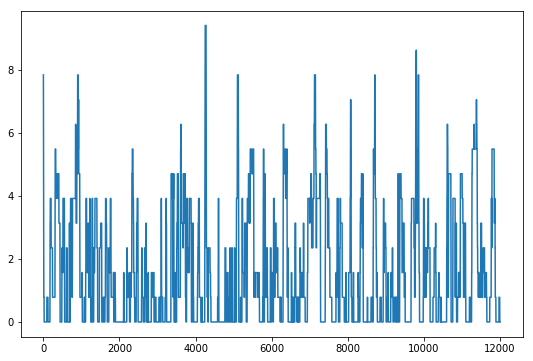

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(x_series)
plt.show()

### Steady State Wealth Distribution

We'll use simulation to compute the steady state wealth distribution.  The other alternative is to use linear algebra with sparse matrices.

For our rather small problem, these methods are probably comparable, but remember that simulation increasingly dominates other methods when the state space becomes large.

Simulation also allows us to fully exploit parallelization.

In [46]:
@njit(parallel=True)
def simulate_stationary_assets(π, 
                               Q, 
                               x_grid, 
                               i_init=10, 
                               j_init=0, 
                               num_households=100_000,
                               ts_length=1000):
    asset_vals = np.empty(num_households)
    for m in prange(num_households):
        i = i_init
        j = j_init

        for t in range(ts_length-1):
            i = π[i, j]
            j = qe.random.draw(np.cumsum(Q[j, :]))
            
        asset_vals[m] = x_grid[i]
        
    return asset_vals

In [21]:
asset_vals = simulate_stationary_assets(π, sp.Q, sp.x_grid)

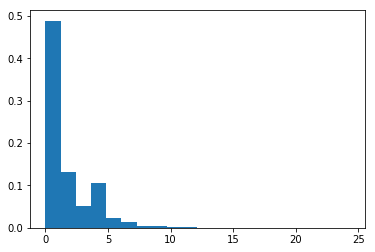

In [22]:
fig, ax = plt.subplots()
ax.hist(asset_vals, bins=20, density=True)
plt.show()            

### Comparative Dynamics

How much capital does the economy supply in steady state?

How does this change as the interest rate varies?

In [23]:
@njit
def jitted_vfi(T, v_init, tol=1e-4, max_iter=1000):

    # Set initial condition, set up storage
    v_in = v_init
    v_out = np.empty_like(v_in)
    π = np.empty_like(v_in, dtype=np.int_)
    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        T(v_in, v_out, π)
        error = np.max(np.abs(v_in - v_out))
        i += 1
        v_in[:] = v_out
    return v_out, π


In [28]:
@njit
def compute_stationary_capital(T, v_init, Q, x_grid, z_grid, sim_length=1_000_000):
    v_out, π = jitted_vfi(T, v_init)
    k = simulate_stationary_assets(π, Q, x_grid).mean()
    return k

In [29]:
sp = SavingsProblem()
T = sp.generate_bellman_operator()
v_init = np.ones((len(sp.x_grid), len(sp.z_grid)))

In [30]:
Q, x_grid, z_grid = sp.Q, sp.x_grid, sp.z_grid
compute_stationary_capital(T, v_init, Q, x_grid, z_grid)

1.5593025078379348

In [33]:
r_vals = np.linspace(0.01, 0.05, 10)
k_vals = np.empty_like(r_vals)
for i, r in enumerate(r_vals):
    sp = SavingsProblem(r=r)
    T = sp.generate_bellman_operator()
    k = compute_stationary_capital(T, v_init, sp.Q, sp.x_grid, sp.z_grid)
    k_vals[i] = k

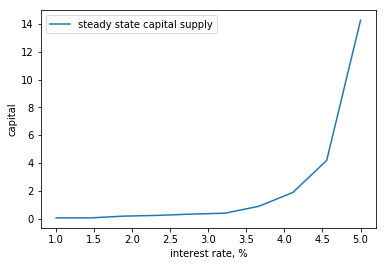

In [36]:
fig, ax = plt.subplots()
ax.plot(r_vals*100, k_vals, label='steady state capital supply')
ax.set_xlabel("interest rate, %")
ax.set_ylabel("capital")
ax.legend()
plt.show()

### Exercise

Now fix the interest rate back at the default level and show how steady state capital supply changes with $\beta$.  What is your prior?  What do you find?

In [37]:
for i in range(30):
    print("solution below!")

solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!
solution below!


### Solution

Here's one solution.  

In [44]:
beta_vals = np.linspace(0.94, 0.97, 5)
k_vals = np.empty_like(beta_vals)
for i, β in enumerate(beta_vals):
    sp = SavingsProblem(β=β)
    T = sp.generate_bellman_operator()
    k = compute_stationary_capital(T, v_init, sp.Q, sp.x_grid, sp.z_grid)
    k_vals[i] = k

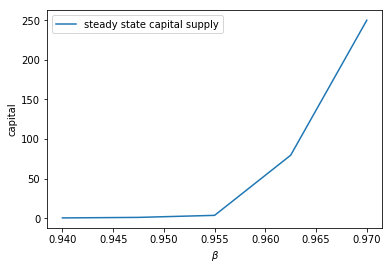

In [45]:
fig, ax = plt.subplots()
ax.plot(beta_vals, k_vals, label='steady state capital supply')
ax.set_xlabel("$\\beta$")
ax.set_ylabel("capital")
ax.legend()
plt.show()

As expected, more patient households tend to hold more assets for a given interest rate.